In earlier scripts I found that the are vast differences in the departments and their share of only full name / abbreviation tagged articles. This script explores the departments with the largest and smallest differences in their share of full name vs. abbreviation tagged articles.

In [2]:
import json
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from src.models.MatchingType import MatchingType

In [6]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [68]:
# get all articles with affiliated authors that are not organizations
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name, a.abbreviation, a.matching_type FROM articles ar join unmapped_article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.matching_type != ?", (MatchingType.ORGANIZATION_MATCH.name, )).fetchall()

In [111]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name', 'abbreviation', 'matching_type'], data=rows)

In [112]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))
departments = departments.explode('department')

In [113]:
departments.loc[departments["matching_type"] == MatchingType.FUZZY_MATCH, "matching_type"] = MatchingType.IS_ABBREVIATION
departments.loc[departments["matching_type"] == MatchingType.DIRECT_MATCH, "matching_type"] = MatchingType.IS_ABBREVIATION


In [114]:
# filter out departments that do not have both the matching_types
departments = departments.groupby('department').filter(lambda x: all(match_type in x['matching_type'].values for match_type in ['IS_ABBREVIATION', 'IS_FULL_NAME']))

In [115]:
# get count for matching type
grouped_departments = departments.groupby(["department", "matching_type"]).size().reset_index(name='count').sort_values(['department', 'matching_type', 'count'], ascending=[True, True, False])

# filter departments with article count less than 1000
grouped_departments = grouped_departments[grouped_departments["count"] > 1000]

In [116]:
# Convert 'matching_type' column to categorical to ensure proper sorting
grouped_departments['matching_type'] = pd.Categorical(grouped_departments['matching_type'], categories=['IS_ABBREVIATION', 'IS_FULL_NAME'], ordered=True)

# Pivot the DataFrame to have separate columns for each matching type
pivoted_departments = grouped_departments.pivot(index='department', columns='matching_type', values='count').reset_index()


# Calculate the difference between the counts of the two matching types
pivoted_departments['count_difference'] = abs(pivoted_departments['IS_ABBREVIATION'] - pivoted_departments['IS_FULL_NAME'])

# Calculate shares
pivoted_departments['abbreviation_share'] = pivoted_departments['IS_ABBREVIATION'] / (pivoted_departments['IS_ABBREVIATION'] + pivoted_departments['IS_FULL_NAME'])
pivoted_departments['full_name_share'] = pivoted_departments['IS_FULL_NAME'] / (pivoted_departments['IS_ABBREVIATION'] + pivoted_departments['IS_FULL_NAME'])

pivoted_departments['share_difference'] = abs(pivoted_departments['abbreviation_share'] - pivoted_departments['full_name_share'])

# Get the top 10 departments with the largest count difference
top_10_departments = pivoted_departments.nlargest(8, 'share_difference')

bottom_10_departments = pivoted_departments.nsmallest(8, 'share_difference')

In [117]:
# Assuming your original dataframe is named df
# You can create a new dataframe with two rows per department
top_results = pd.DataFrame()

for index, row in top_10_departments.iterrows():
    department = row['department']
    abbreviation_share = row['abbreviation_share'] * 100
    full_name_share = row['full_name_share'] * 100
    abbreviation_count = row["IS_ABBREVIATION"]
    full_name_count = row["IS_FULL_NAME"]

    # Create a new dataframe for abbreviation share
    df_abbreviation = pd.DataFrame({'department': [department], 'share': [abbreviation_share], 'share_type': ['abbreviation'], 'count': abbreviation_count})


    # Create a new dataframe for full name share
    df_full_name = pd.DataFrame({'department': [department], 'share': [full_name_share], 'share_type': ['full_name'], 'count': full_name_count})

    # Concatenate the new dataframes to the main dataframe
    top_results = pd.concat([top_results, df_abbreviation, df_full_name], ignore_index=True)


In [118]:
# Assuming your original dataframe is named df
# You can create a new dataframe with two rows per department
bottom_results = pd.DataFrame()

for index, row in bottom_10_departments.iterrows():
    department = row['department']
    abbreviation_share = row['abbreviation_share'] * 100
    full_name_share = row['full_name_share'] * 100
    abbreviation_count = row["IS_ABBREVIATION"]
    full_name_count = row["IS_FULL_NAME"]

    # Create a new dataframe for abbreviation share
    df_abbreviation = pd.DataFrame({'department': [department], 'share': [abbreviation_share], 'share_type': ['abbreviation'], 'count': abbreviation_count})

    # Create a new dataframe for full name share
    df_full_name = pd.DataFrame({'department': [department], 'share': [full_name_share], 'share_type': ['full_name'], 'count': full_name_count})

    # Concatenate the new dataframes to the main dataframe
    bottom_results = pd.concat([bottom_results, df_abbreviation, df_full_name], ignore_index=True)


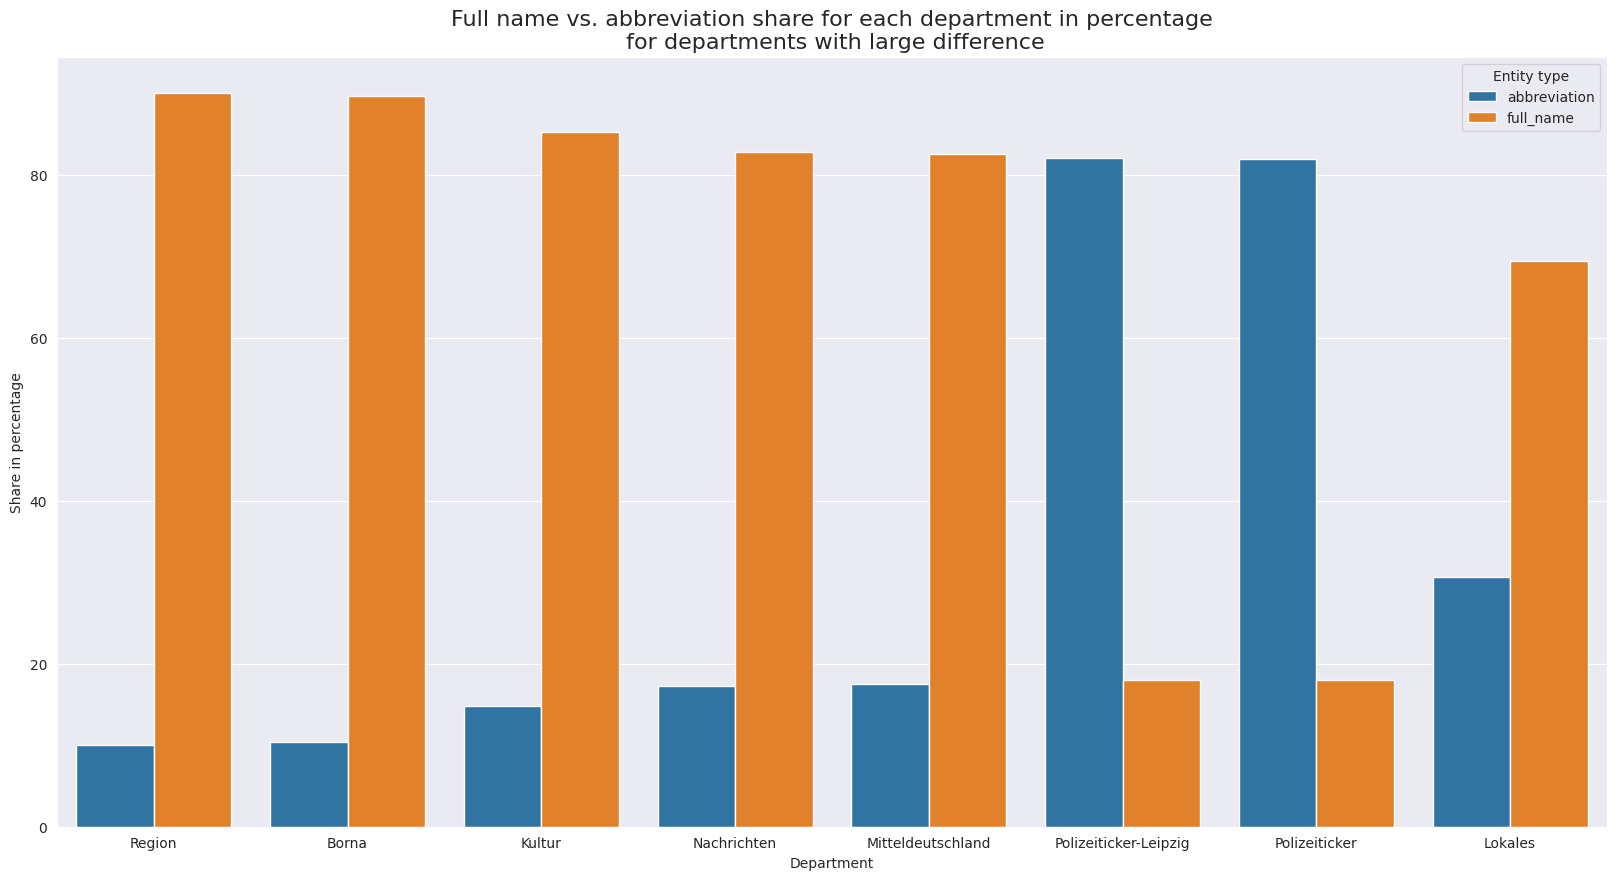

In [119]:
# increase figsize
plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(x="department", y="share", hue="share_type", data=top_results)

# set title
plt.title("Full name vs. abbreviation share for each department in percentage\n for departments with large difference", fontsize=16)

# set x label
plt.xlabel("Department")
# set y label
plt.ylabel("Share in percentage")
# set legend title
plt.legend(title="Entity type")
# save plot
plt.savefig("../reports/figures/department_exploration/top_departments_full_name_vs_abbreviations_share.png")


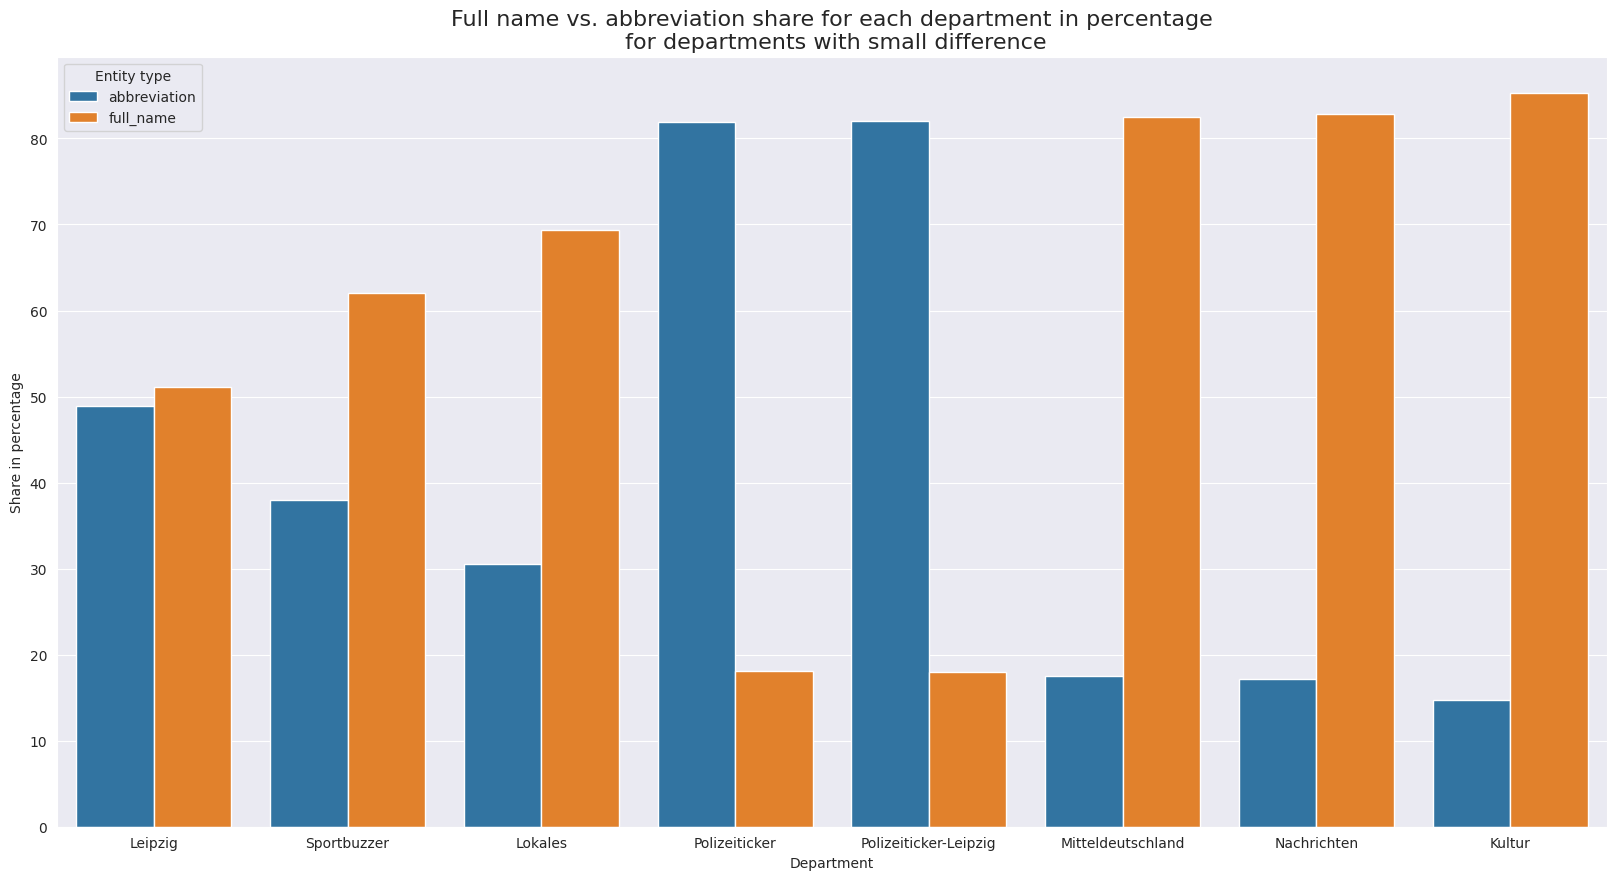

In [120]:
# increase figsize
plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(x="department", y="share", hue="share_type", data=bottom_results)

# set title
plt.title("Full name vs. abbreviation share for each department in percentage\n for departments with small difference", fontsize=16)

# set x label
plt.xlabel("Department")
# set y label
plt.ylabel("Share in percentage")
# set legend title
plt.legend(title="Entity type")
# save plot
plt.savefig("../reports/figures/department_exploration/bottom_departments_full_name_vs_abbreviations_share.png")

In [121]:
bottom_results

,department,share,share_type,count
0,Leipzig,48.846710,abbreviation,19250.0
1,Leipzig,51.153290,full_name,20159.0
2,Sportbuzzer,37.924016,abbreviation,2236.0
3,Sportbuzzer,62.075984,full_name,3660.0
4,Lokales,30.592257,abbreviation,6622.0
5,Lokales,69.407743,full_name,15024.0
6,Polizeiticker,81.941616,abbreviation,13277.0
7,Polizeiticker,18.058384,full_name,2926.0
8,Polizeiticker-Leipzig,82.035500,abbreviation,11462.0
9,Polizeiticker-Leipzig,17.964500,full_name,2510.0
